# Cooling Tank Model Optimization

This notebook demonstrates the optimization of the tank model described in `tank_optimization_model.py` using the `ProblemInterface` class in the `fmdtools.search` module. 

Note that this problem/notebook was loosely adapted from the identical problem here: https://github.com/DesignEngrLab/resil_opt_examples/tree/main/Cooling%20Tank%20Problem, which shows more comparisions of these architectures running on an earlier version of fmdtools. 

```
Copyright © 2024, United States Government, as represented by the Administrator of the National Aeronautics and Space Administration. All rights reserved.

The “"Fault Model Design tools - fmdtools version 2"” software is licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0. 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
```

In [1]:
from tank_optimization_model import Tank
from fmdtools.define.architecture.function import FunctionArchitectureGraph
from fmdtools.sim import propagate as prop


# Simulation

### Verifying the nominal state:

In the nominal state, no change in system state should occurs. Flows will be constant and no signal is on.

In [2]:
mdl = Tank()
result, mdlhist = prop.nominal(mdl, track='all', desired_result={'graph': FunctionArchitectureGraph})

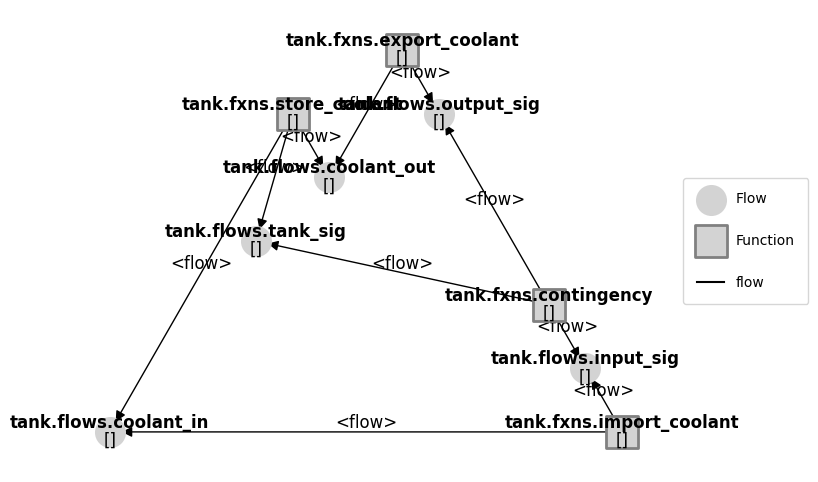

In [3]:
fig = result.graph.draw(figsize=(8,6))

In [4]:
mdlhist

flows.coolant_in.s.effort:     array(21)
flows.coolant_in.s.rate:       array(21)
flows.coolant_out.s.effort:    array(21)
flows.coolant_out.s.rate:      array(21)
flows.input_sig.s.indicator:   array(21)
flows.input_sig.s.action:      array(21)
flows.tank_sig.s.indicator:    array(21)
flows.tank_sig.s.action:       array(21)
flows.output_sig.s.indicator:  array(21)
flows.output_sig.s.action:     array(21)
fxns.import_coolant.s.amt_open: array(21)
fxns.import_coolant.m.faults.stuck: array(21)
fxns.import_coolant.m.faults.blockage: array(21)
fxns.store_coolant.s.level:    array(21)
fxns.store_coolant.s.net_flow: array(21)
fxns.store_coolant.s.coolingbuffer: array(21)
fxns.store_coolant.m.faults.leak: array(21)
fxns.export_coolant.s.amt_open: array(21)
fxns.export_coolant.m.faults.stuck: array(21)
fxns.export_coolant.m.faults.blockage: array(21)
time:                          array(21)

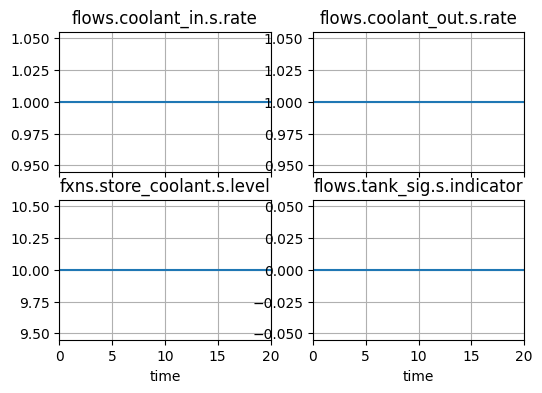

In [5]:
fig, ax = mdlhist.plot_line('flows.coolant_in.s.rate', 'flows.coolant_out.s.rate', 'fxns.store_coolant.s.level', 'flows.tank_sig.s.indicator')

### What happens under component faults?


Here we model a leak of the tank. As shown, the coolant leaks until there is no more coolant left in the tank. While this results in a warning signal, the default contingency management policy is to take no actions to alleviate the condition.

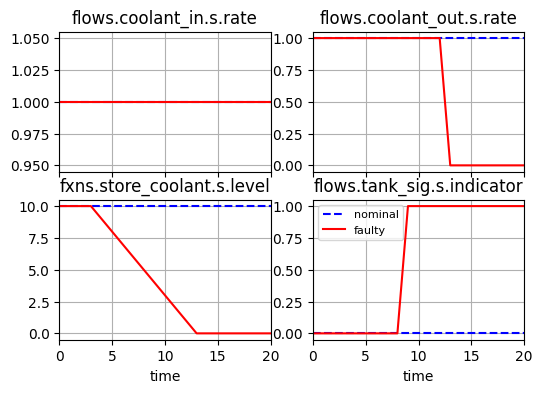

In [6]:
resgraph, mdlhist = prop.one_fault(mdl,'store_coolant','leak', time=3, track='all',desired_result=['graph','endclass','endfaults'])

fig, ax = mdlhist.plot_line('flows.coolant_in.s.rate', 'flows.coolant_out.s.rate', 'fxns.store_coolant.s.level', 'flows.tank_sig.s.indicator')

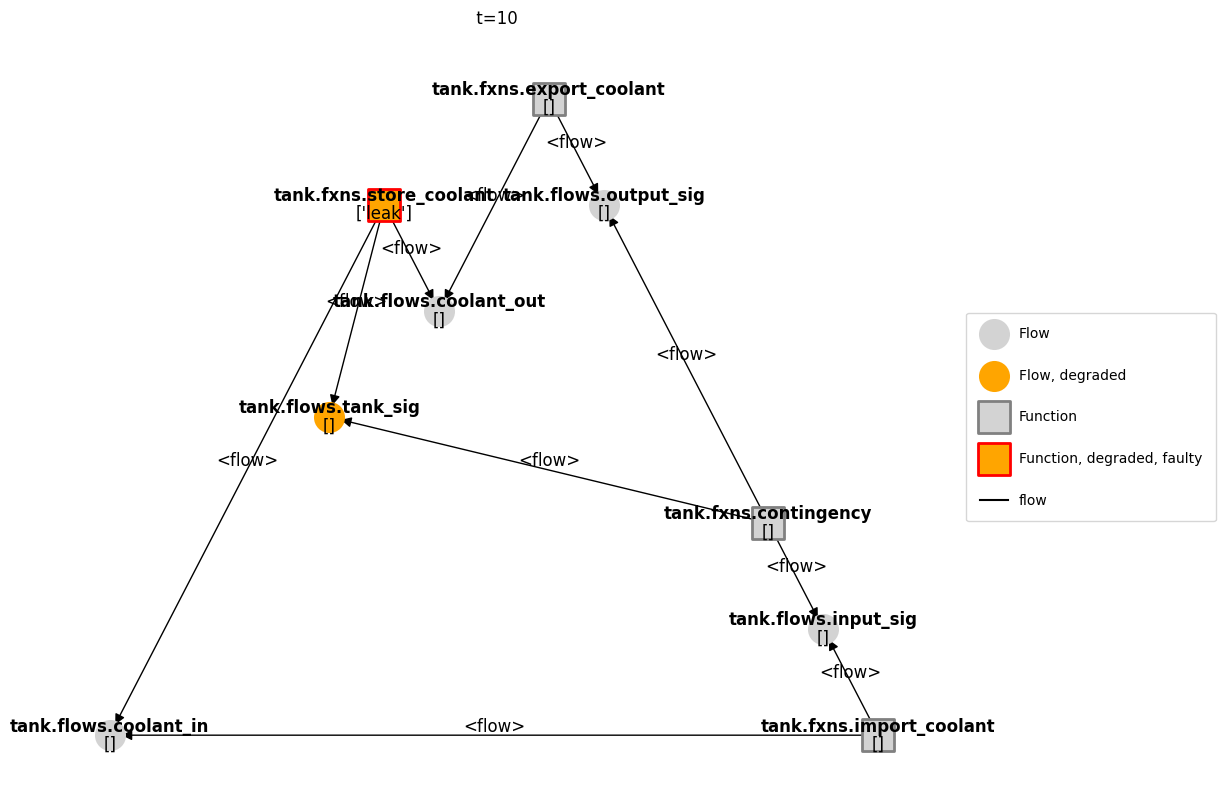

In [7]:
mg = FunctionArchitectureGraph(mdl)
fig, ax = mg.draw_from(10, mdlhist)

### Full set of modes

The tank leak mode will not be the only mode considered, but also leak and blockage faults in the Input/Output blocks.

In [8]:
from fmdtools.sim.sample import FaultDomain, FaultSample
fd = FaultDomain(mdl)
fd.add_all()
fd

FaultDomain with faults:
 -('import_coolant', 'stuck')
 -('import_coolant', 'blockage')
 -('store_coolant', 'leak')
 -('export_coolant', 'stuck')
 -('export_coolant', 'blockage')

In [9]:
fs = FaultSample(fd)
fs.add_fault_phases("na")
fs

FaultSample of scenarios: 
 - import_coolant_stuck_t0p0
 - import_coolant_blockage_t0p0
 - store_coolant_leak_t0p0
 - export_coolant_stuck_t0p0
 - export_coolant_blockage_t0p0

We can then verify the faulty results:

In [10]:
endclasses, mdlhists = prop.fault_sample(mdl, fs)

SCENARIOS COMPLETE: 100%|██████████| 5/5 [00:00<00:00, 108.70it/s]


In [11]:
from fmdtools.analyze.tabulate import result_summary_fmea
fmea_tab = result_summary_fmea(endclasses, mdlhists)
fmea_tab

,degraded,faulty,rate,cost,expected_cost
import_coolant_stuck_t0p0,[],[],0.0,0.0,0.0
import_coolant_blockage_t0p0,[],[],0.0,2100000.0,35000.0
store_coolant_leak_t0p0,[],[],0.00001,1000000.0,1000000.0
export_coolant_stuck_t0p0,[],[],0.0,0.0,0.0
export_coolant_blockage_t0p0,[],[],0.0,100000.0,1666.666667
nominal,[],[],1.0,0.0,0.0


### Defining Optimization Problem

We can define a compbined optimization problem around this model using the `OptimizationArchitecture`, `ParameterSimProblem`, and `SimpleProblem` classes.

In this case, we consider the joint minimization of design cost (defined in a function) and resilience cost (expected cost over the above list of scenarios). This is over two sets of variables

- capacity and turnup (design variables that effect both design and resilience costs), and
- the resilience policy (variables that only effect resilience cost)

To model design cost (which does not involve simulation), we first define a `SimpleProblem` which calls a predefined function:

In [12]:
def x_to_descost(*xdes):
    pen = 0 #determining upper-level penalty
    if xdes[0]<10:
        pen+=1e5*(10-xdes[0])**2
    if xdes[0]>100:
        pen+=1e5*(100-xdes[0])**2
    if xdes[1]<0:
        pen+=1e5*(xdes[1])**2
    if xdes[1]>1:
        pen+=1e5*(1-xdes[1])**2
    return (xdes[0]-10)*1000 + (xdes[0]-10)**2*1000   + xdes[1]**2*10000 + pen

In [13]:
from fmdtools.sim.search import SimpleProblem
sp = SimpleProblem("capacity", "turnup")
sp.add_objective("cd", x_to_descost)

In [14]:
sp.cd(1, 1)

8182000.0

In [15]:
sp

SimpleProblem with:
VARIABLES
 -capacity                                                   1.0000
 -turnup                                                     1.0000
OBJECTIVES
 -cd                                                   8182000.0000

To optimize resilience costs, we can additionally use `ParameterSimProblem`:

In [16]:
from fmdtools.sim.search import ParameterSimProblem
from fmdtools.sim.sample import ParameterDomain

The `ParameterDomain` is defined by "capacity" and "turnup" variables, as well as the resilience policy:

In [17]:
from tank_optimization_model import TankParam
pd = ParameterDomain(TankParam)
pd.add_variables("capacity", "turnup")

The resilience policy is translated using `x_to_fp`

In [18]:
from tank_optimization_model import x_to_fp
fp_varnames = ['faultpolicy.'+str(i) for i, v in enumerate(TankParam.__defaults__['faultpolicy'])]
pd.add_variables(*fp_varnames, var_map=x_to_fp)

In [19]:
fp_vars = [1 for i, v in enumerate(TankParam.__defaults__['faultpolicy'])]

In [20]:
pd(1, 1, *fp_vars)

TankParam(capacity=1.0, turnup=1.0, faultpolicy=((-1, -1, -1, 'l', 1), (-1, -1, 0, 'l', 1), (-1, -1, 1, 'l', 1), (-1, 0, -1, 'l', 1), (-1, 0, 0, 'l', 1), (-1, 0, 1, 'l', 1), (-1, 1, -1, 'l', 1), (-1, 1, 0, 'l', 1), (-1, 1, 1, 'l', 1), (0, -1, -1, 'l', 1), (0, -1, 0, 'l', 1), (0, -1, 1, 'l', 1), (0, 0, -1, 'l', 1), (0, 0, 0, 'l', 1), (0, 0, 1, 'l', 1), (0, 1, -1, 'l', 1), (0, 1, 0, 'l', 1), (0, 1, 1, 'l', 1), (1, -1, -1, 'l', 1), (1, -1, 0, 'l', 1), (1, -1, 1, 'l', 1), (1, 0, -1, 'l', 1), (1, 0, 0, 'l', 1), (1, 0, 1, 'l', 1), (1, 1, -1, 'l', 1), (1, 1, 0, 'l', 1), (1, 1, 1, 'l', 1), (-1, -1, -1, 'u', 1), (-1, -1, 0, 'u', 1), (-1, -1, 1, 'u', 1), (-1, 0, -1, 'u', 1), (-1, 0, 0, 'u', 1), (-1, 0, 1, 'u', 1), (-1, 1, -1, 'u', 1), (-1, 1, 0, 'u', 1), (-1, 1, 1, 'u', 1), (0, -1, -1, 'u', 1), (0, -1, 0, 'u', 1), (0, -1, 1, 'u', 1), (0, 0, -1, 'u', 1), (0, 0, 0, 'u', 1), (0, 0, 1, 'u', 1), (0, 1, -1, 'u', 1), (0, 1, 0, 'u', 1), (0, 1, 1, 'u', 1), (1, -1, -1, 'u', 1), (1, -1, 0, 'u', 1), (1, -1,

In [21]:
pd

ParameterDomain with:
 - variables: {'capacity': (), 'turnup': (), 'faultpolicy.0': (), 'faultpolicy.1': (), 'faultpolicy.2': (), 'faultpolicy.3': (), 'faultpolicy.4': (), 'faultpolicy.5': (), 'faultpolicy.6': (), 'faultpolicy.7': (), 'faultpolicy.8': (), 'faultpolicy.9': (), 'faultpolicy.10': (), 'faultpolicy.11': (), 'faultpolicy.12': (), 'faultpolicy.13': (), 'faultpolicy.14': (), 'faultpolicy.15': (), 'faultpolicy.16': (), 'faultpolicy.17': (), 'faultpolicy.18': (), 'faultpolicy.19': (), 'faultpolicy.20': (), 'faultpolicy.21': (), 'faultpolicy.22': (), 'faultpolicy.23': (), 'faultpolicy.24': (), 'faultpolicy.25': (), 'faultpolicy.26': (), 'faultpolicy.27': (), 'faultpolicy.28': (), 'faultpolicy.29': (), 'faultpolicy.30': (), 'faultpolicy.31': (), 'faultpolicy.32': (), 'faultpolicy.33': (), 'faultpolicy.34': (), 'faultpolicy.35': (), 'faultpolicy.36': (), 'faultpolicy.37': (), 'faultpolicy.38': (), 'faultpolicy.39': (), 'faultpolicy.40': (), 'faultpolicy.41': (), 'faultpolicy.42': (

Which we then use to define the problem:

In [22]:
from multiprocessing import Pool
psp = ParameterSimProblem(mdl, pd, "fault_sample", fs, pool=Pool(5), close_pool=False)
psp.add_result_objective("cr", "endclass.expected_cost")

In [23]:
psp.cr(1, 2, *fp_vars)

4201123133.3333335

In [24]:
psp.cr(0.5, 1, *fp_vars)

4201124800.0

Since the design variables affect both design and resilience costs, we can connect these two problems in an overall `ProblemArchitecture` where design cost evaluation feeds into resilience cost evaluation.

First, we define a simpleproblem to combine the objectives:

In [25]:
def tot(c_d, c_o):
    return c_d + c_o
tot_sp = SimpleProblem("cd", "cr")
tot_sp.add_objective("tot_cost", tot)
tot_sp.tot_cost(1, 1)

2

In [26]:
from fmdtools.sim.search import ProblemArchitecture
pa = ProblemArchitecture()

In [27]:
pa.add_connector_variable("xd", "capacity", "turnup")
pa.add_connector_objective("dcost", "cd")
pa.add_connector_objective("rcost", "cr")

In [28]:
pa.add_problem("des", sp, outputs={"xd": ("capacity", "turnup"), "dcost": ("cd", )})
pa.add_problem("res", psp, inputs={"xd": ("capacity", "turnup")}, outputs={"rcost": ("cr", )})
pa.add_problem("tot", tot_sp, inputs={"dcost": ("cd", ), "rcost": ("cr", )})

We can then visualize/verify the setup of this using:

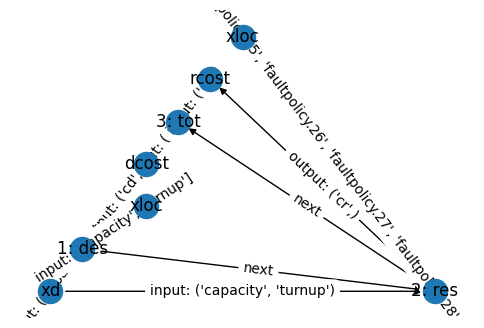

In [29]:
fig, ax = pa.show_sequence()

In [30]:
pa.connectors['xd']

VariableConnector(name='xd', keys=('capacity', 'turnup'), values=array([nan, nan]))

In [31]:
pa

ProblemArchitecture with:
CONNECTORS
 -xd                                                      [nan nan]
 -dcost                                                       [nan]
 -rcost                                                       [nan]
PROBLEMS
 -des({'des_xloc': ['capacity', 'turnup']}) -> ['xd', 'dcost']
 -res({'xd': ('capacity', 'turnup'), 'res_xloc': ['faultpolicy.0', 'faultpolicy.1', 'faultpolicy.2', 'faultpolicy.3', 'faultpolicy.4', 'faultpolicy.5', 'faultpolicy.6', 'faultpolicy.7', 'faultpolicy.8', 'faultpolicy.9', 'faultpolicy.10', 'faultpolicy.11', 'faultpolicy.12', 'faultpolicy.13', 'faultpolicy.14', 'faultpolicy.15', 'faultpolicy.16', 'faultpolicy.17', 'faultpolicy.18', 'faultpolicy.19', 'faultpolicy.20', 'faultpolicy.21', 'faultpolicy.22', 'faultpolicy.23', 'faultpolicy.24', 'faultpolicy.25', 'faultpolicy.26', 'faultpolicy.27', 'faultpolicy.28', 'faultpolicy.29', 'faultpolicy.30', 'faultpolicy.31', 'faultpolicy.32', 'faultpolicy.33', 'faultpolicy.34', 'faultpolicy.35',

We can also evaluate the objectives in terms of full or partial sets of the variables:

In [32]:
fp_vars = [0 for i, v in enumerate(TankParam.__defaults__['faultpolicy'])]
pa.res_cr_full(0.5, 1.0, *fp_vars)

1081666.6666666667

In [33]:
pa

ProblemArchitecture with:
CONNECTORS
 -xd                                                      [0.5 1. ]
 -dcost                                                  [9115750.]
 -rcost                                          [1081666.66666667]
PROBLEMS
 -des({'des_xloc': ['capacity', 'turnup']}) -> ['xd', 'dcost']
 -res({'xd': ('capacity', 'turnup'), 'res_xloc': ['faultpolicy.0', 'faultpolicy.1', 'faultpolicy.2', 'faultpolicy.3', 'faultpolicy.4', 'faultpolicy.5', 'faultpolicy.6', 'faultpolicy.7', 'faultpolicy.8', 'faultpolicy.9', 'faultpolicy.10', 'faultpolicy.11', 'faultpolicy.12', 'faultpolicy.13', 'faultpolicy.14', 'faultpolicy.15', 'faultpolicy.16', 'faultpolicy.17', 'faultpolicy.18', 'faultpolicy.19', 'faultpolicy.20', 'faultpolicy.21', 'faultpolicy.22', 'faultpolicy.23', 'faultpolicy.24', 'faultpolicy.25', 'faultpolicy.26', 'faultpolicy.27', 'faultpolicy.28', 'faultpolicy.29', 'faultpolicy.30', 'faultpolicy.31', 'faultpolicy.32', 'faultpolicy.33', 'faultpolicy.34', 'faultpolicy.35',

In [34]:
pa.tot_tot_cost_full(0.5, 1.0, *fp_vars)

10197416.666666666

Note that because the simulations are linked, changes to xdes in the `cd` function in turn change the lower-level `cost` function by default.

In [35]:
pa.des_cd(1,1)

8182000.0

In [36]:
pa.res_cr(*fp_vars)

1081666.6666666667

In [37]:
pa.tot_tot_cost()


9263666.666666666

### Optimization

This problem is optimized here using four different architectures, following the example in:

Hulse, D., & Hoyle, C. (2022). Understanding Resilience Optimization Architectures: Alignment and Coupling in Multilevel Decomposition Strategies. Journal of Mechanical Design, 144(11), 111704.

The optimization of the resilience policy is accomplished using an evolutionary algorithm, defined below:

In [38]:
import numpy as np
import random
def EA(prob_callable, popsize=10, iters=20, mutations=3, crossovers=2, numselect=3, verbose=True, args={}):
    # generate initial population:
    randpopsize = popsize-numselect-mutations - crossovers
    opers = [randpop, mutepop, crossover]
    numopers = [randpopsize, mutations, crossovers]
    used_opers = [oper for i, oper in enumerate(opers) if numopers[i] > 0]
    used_numopers = [numoper for numoper in numopers if numoper > 0]
    if args:
        pop = np.concatenate((args['seed'], seedpop(), randpop([], popsize-3)))
    else:
        pop = np.concatenate((seedpop(), randpop([], popsize-3)))
    makefeasible(pop)
    # evaluate initial population
    values = np.array([prob_callable(*[*x[0], *x[1]]) for x in pop])
    # gen/evaluate mutated population
    for i in range(iters):
        goodpop, goodvals = select(pop, values, numselect)
        newpop = np.concatenate(tuple([oper(goodpop, used_numopers[i]) for i, oper in enumerate(used_opers)]))
        makefeasible(newpop)
        newvals = np.array([prob_callable(*[*x[0], *x[1]]) for x in newpop])
        pop, values = np.concatenate(
            (goodpop, newpop)), np.concatenate((goodvals, newvals))
        if verbose == "iters":
            print(["iter "+str(i)+": ", min(values)])
    minind = np.argmin(values)
    if args:
        args['seed'] = goodpop
        args['ll_opt'] = values[minind]
        args['ll_optx'] = pop[minind]
    if verbose == "final":
        print(values[minind])
    return pop[minind], values[minind]


possible_sols = [[-1, -1], [-1, 0], [-1, 1],
                 [0, -1], [0, 0], [0, 1], [1, -1], [1, 0], [1, 1]]


def randpop(goodpop, popsize):
    return np.array([[[random.randint(-1, 1) for a in range(0, 27)],
                      [random.randint(-1, 1) for a in range(0, 27)]]
                     for i in range(0, popsize)])


def seedpop():
    donothing = np.zeros((2, 27))
    adjustup = np.ones((2, 27))
    adjustdown = -np.ones((2, 27))
    return np.array([donothing, adjustup, adjustdown])


def mutepop(goodpop, mutations):
    to_mutate = np.random.choice(
        [i for i in range(len(goodpop))], size=mutations, replace=False)
    return np.array([permute(solution) for solution in goodpop[to_mutate]])


def permute(solution):
    mutation = possible_sols[random.randint(0, 8)]
    to_mutate = random.randint(0, 26)
    solution[0][to_mutate] = mutation[0]
    solution[1][to_mutate] = mutation[1]
    return solution


def crossover(goodpop, crossovers):
    to_cross = np.random.choice(
        [i for i in range(len(goodpop))], size=crossovers, replace=False)
    divider = np.random.randint(1, 25)
    swap = np.random.choice([i for i in range(crossovers)],
                            size=crossovers, replace=False)
    return np.array([[np.concatenate((goodpop[to_cross[i]][0][:divider], goodpop[to_cross[swap[i]]][0][divider:])), np.concatenate((goodpop[to_cross[i]][1][:divider], goodpop[to_cross[swap[i]]][1][divider:]))] for i in range(crossovers)])


def select(solutions, values, numselect):
    selection = np.argsort(values)[0:numselect]
    return solutions[selection], values[selection]


def makefeasible(population):
    for sol in population:
        sol[0][13] = 0
        sol[1][13] = 0

In [39]:
pop, vals = EA(pa.res_cr, verbose = 'iters')

['iter 0: ', 1081666.6666666667]
['iter 1: ', 1081666.6666666667]
['iter 2: ', 1081666.6666666667]
['iter 3: ', 1081666.6666666667]
['iter 4: ', 1081666.6666666667]
['iter 5: ', 1081666.6666666667]
['iter 6: ', 1081666.6666666667]
['iter 7: ', 1081666.6666666667]
['iter 8: ', 1081666.6666666667]
['iter 9: ', 1081666.6666666667]
['iter 10: ', 1081666.6666666667]
['iter 11: ', 1081666.6666666667]
['iter 12: ', 1081666.6666666667]
['iter 13: ', 1081666.6666666667]
['iter 14: ', 1081666.6666666667]
['iter 15: ', 1081666.6666666667]
['iter 16: ', 1081666.6666666667]
['iter 17: ', 1081666.6666666667]
['iter 18: ', 1081666.6666666667]
['iter 19: ', 1081666.6666666667]


C:\Users\dhulse\Documents\GitHub\fmdtools\fmdtools\sim\search.py:349: RuntimeWarning: All-NaN slice encountered
  hist[val] = [np.nanmin(arr[:i]) for i in range(1, len(arr)+1)]


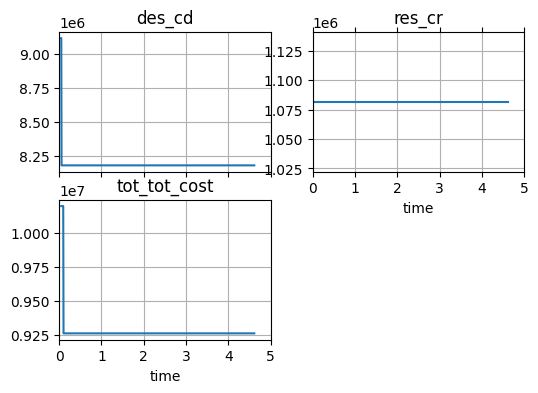

In [41]:
fig, axs = pa.plot_opt_hist()

#### Alternating Optimization

Which can then be optimized in an alternating or bilevel optimization structure:

In [41]:
from scipy.optimize import minimize

def sub_totcost(tot_cost_callable):
    def new_func(xres, args):
        return tot_cost_callable(*xres, *args)
    return new_func

def alternating_opt(tot_cost_callable, dcost_callable, rcost_callable, option='with_cr', pool=False, xdes=[21, .5], max_alts=10):
    xdes = np.array(xdes)
    args = {'seed': seedpop(), 'll_opt': 1e6, 'll_optx': []}
    newmin = 100000000
    lastmin = 1000000001
    bestsol = np.zeros(54)
    last_run = False
    fhist = []
    thist = [0]
    xdhist = [xdes]
    for n in range(max_alts):
        if option == 'with_cr':
            tot_cost_call = sub_totcost(tot_cost_callable)
            result = minimize(tot_cost_call,
                              [np.round(xdes[0], 1), np.round(xdes[1], 1)],
                              method='Nelder-Mead',
                              bounds=((10, 100), (0, 1)),
                              callback=callbackF1,
                              args=bestsol,
                              options={'disp': True})
        else:
            result = minimize(dcost_callable,
                              [np.round(xdes[0], 1),
                               np.round(xdes[1], 1)],
                              method='Nelder-Mead',
                              bounds=((10, 100), (0, 1)),
                              callback=callbackF1,
                              options={'disp': True})
        xdes = result['x']
        dcost = dcost_callable(*xdes)
        bestpop, rcost = EA(rcost_callable, args=args, popsize=50, mutations=10,
                            numselect=20, crossovers=5, iters=100, verbose="iters")
        bestsol = [*bestpop[0], *bestpop[1]]
        lastmin = newmin
        newmin = dcost + rcost
        fhist.append(newmin)
        xdhist.append(xdes)
        print(n, newmin, lastmin-newmin)
        if lastmin - newmin < 0.1:
            if last_run:
                break
            else:
                last_run = True
        else:
            last_run = False
        fhist.append(newmin)
    return result, args, fhist, thist, xdhist


def callbackF(Xdes, result):
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}'.format(
        result['nit'], Xdes[0], Xdes[1], result['fun']))


def callbackF1(Xdes):
    print(Xdes)

In [42]:
result, args, fhist, thist, xdhist = alternating_opt(pa.tot_tot_cost_full, pa.des_cd, pa.res_cr, max_alts=1)

[18.9     0.5375]
[17.85     0.50625]
[13.125     0.565625]


[12.075     0.534375]
[12.075     0.534375]
[12.075     0.534375]
[12.075     0.503125]


[12.075     0.503125]
[12.075     0.503125]


[12.075     0.503125]
[12.075     0.503125]
[12.075     0.503125]


[12.01015625  0.50839844]
[12.01015625  0.50058594]
[12.01015625  0.50058594]


[12.01015625  0.50058594]
[12.01015625  0.50058594]
[12.01015625  0.50058594]
[12.00610352  0.48699951]


[12.00610352  0.48699951]
[12.00863647  0.47205353]
[12.00154419  0.46390228]


[12.00306396  0.42993469]
[12.00306396  0.42993469]
[12.00971298  0.40632648]


[12.00822487  0.33541975]
[12.02077885  0.25274997]
[12.02407961  0.06960161]
[12.02407961  0.06960161]


[12.02407961  0.06960161]
[12.0225915   0.06960161]
[12.02924051  0.0348008 ]


[12.0277524  0.0348008]
[12.0277524  0.0348008]
[12.02146354  0.06090141]


[12.02273595  0.0391509 ]
[12.01079444  0.08047686]
[12.00736851  0.05763883]


[12.00736851  0.05763883]
[12.00736851  0.05763883]
[12.00394258  0.0348008 ]
[12.00394258  0.0348008 ]


[12.00478061  0.        ]
[12.00478061  0.        ]
[1.20020078e+01 6.72906165e-03]
[1.20020078e+01 6.72906165e-03]


[1.20000730e+01 6.72906165e-03]
[1.20000730e+01 6.72906165e-03]
[1.20000084e+01 3.36453082e-03]
[1.20000084e+01 3.36453082e-03]


[1.20000084e+01 3.36453082e-03]
[1.20000084e+01 3.36453082e-03]
[1.20000084e+01 3.36453082e-03]


[1.20000084e+01 3.36453082e-03]
[1.20000084e+01 3.36453082e-03]
[1.20000084e+01 3.36453082e-03]
[1.20000084e+01 3.36453082e-03]


[1.20000023e+01 1.87283454e-03]
[1.20000023e+01 1.87283454e-03]
[1.20000023e+01 1.87283454e-03]
[1.20000023e+01 1.87283454e-03]


[1.20000024e+01 8.16900855e-04]
[1.20000024e+01 8.16900855e-04]
[1.20000024e+01 8.16900855e-04]
[1.20000024e+01 8.16900855e-04]


[12.00000087  0.        ]
[12.00000087  0.        ]
[12.00000087  0.        ]
[12.00000087  0.        ]


[12.00000041  0.        ]
[12.00000041  0.        ]
[12.00000041  0.        ]


[12.0000003  0.       ]
[12.0000003  0.       ]
[12.0000001  0.       ]


[12.0000001  0.       ]
[12.0000001  0.       ]
[12.0000001  0.       ]


[12.0000001  0.       ]
[12.00000005  0.        ]
[12.00000001  0.        ]


[12.00000001  0.        ]
[12.00000001  0.        ]
[12.00000001  0.        ]


[12.00000001  0.        ]
[12.00000001  0.        ]
Optimization terminated successfully.
         Current function value: 1057666.666717
         Iterations: 86
         Function evaluations: 167


['iter 0: ', 1051666.6666666667]


['iter 1: ', 1051666.6666666667]


['iter 2: ', 1051666.6666666667]


['iter 3: ', 1051666.6666666667]


['iter 4: ', 1051666.6666666667]


['iter 5: ', 1051666.6666666667]


['iter 6: ', 1050000.0]


['iter 7: ', 1049900.0]


['iter 8: ', 1049900.0]


KeyboardInterrupt: 

#### Bilevel Optimization:

Additionally, a bilevel optimization would look like this:

Bilevel optimizations have a lower level which is called repeatedly, see below:

In [50]:
def lower_level(xdes, args= {}):
    if not args:
        args = {'seed': seedpop(), 'll_opt': 1e6, 'll_optx': [], 'fhist': []}
    do_cost = pa.des_cd(*xdes)
    bestsol, rcost = EA(pa.res_cr, popsize=20, mutations=6, crossovers=4, numselect=6, args=args)
    f = do_cost + rcost
    args['fhist'].append(f)
    print(' fval: '+str(f)+' xdes: '+str(xdes))
    return f

In [51]:
lower_level([1,1])

This is then called in bilevel_opt:

In [52]:
def bilevel_opt(xdes=[21, .5], maxiter=1000):
    args = {'seed': seedpop(), 'll_opt': 1e6, 'll_optx': [], 'fhist': [],
            'thist': [], 'xdhist': [xdes]}
    result = minimize(lower_level,
                      xdes,
                      method='Nelder-Mead',
                      bounds=((10, 100), (0, 1)),
                      callback=callbackF1,
                      args=args,
                      options={'disp': True, 'adaptive': True, 'fatol': 10, 'xtol': 0.00001, 'maxiter': maxiter})
    fullfhist = args['fhist']
    fullxdhist = args['xdhist']
    bestfhist = [fullfhist[0]]+[min(fullfhist[:i])
                                for i, f in enumerate(fullfhist) if i != 0]
    return result, args, bestfhist

In [53]:
bilevel_opt(maxiter=2)

In [ ]:
pool.close()
pool.terminate()

Note that these are the previously-recorded results for different strategies:

|               |    𝑥_t      |   𝑥_l   |       𝑓     |    time     |
|--------------------|----------:|---------:|--------------:|------------|
|            Bilevel | 18.000015 | 0.580982 | 285708.991759 | 619.369699 |
|   Alt. (no  𝐶 𝑅CR) | 10.000000 | 0.000000 | 893333.333333 | 168.275383 |
| Alt. (with  𝐶 𝑅CR) | 20.000000 | 0.000000 | 452666.666823 | 306.776320 |
| Seq. (with  𝐶 𝑅CR) | 22.000000 | 0.000000 | 466333.333389 |  61.702104 |
|   Seq. (no  𝐶 𝑅CR) | 10.000000 | 0.000000 | 893333.333333 |  55.957946 |

Generally, we would expect results to be somewhat consistent with this (not exactly, since the lower-level EA is a stochastic search), however, there have been many changes to the underlying toolkit/model, as well as the tank model which may lead to different results.